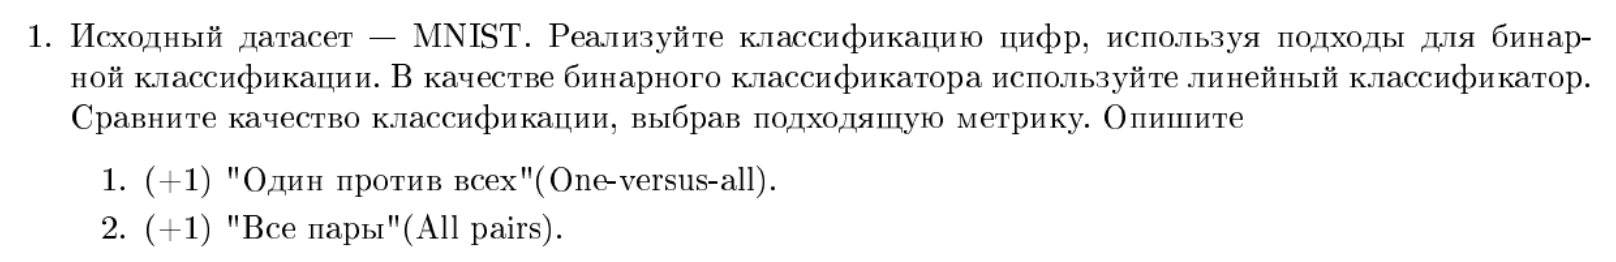

In [1]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.linear_model import SGDClassifier
from itertools import permutations, combinations

In [2]:
train_df = pd.read_csv('./mnist_train.csv', header=None)
test_df = pd.read_csv('./mnist_test.csv', header=None)

N = 785
X = train_df[range(1, N)].values
y = train_df[0].values
X_test = test_df[range(1, N)].values
y_test = test_df[0].values

### Один против всех

In [3]:
one_classifiers = {}
for c in tqdm(range(10)):
    cur_y = (y == c)
    clf = SGDClassifier()
    clf.fit(X, cur_y)
    one_classifiers[c] = clf

100%|██████████| 10/10 [02:12<00:00, 13.24s/it]


In [4]:
corrects_count = 0
for x_true, y_true in tqdm(zip(X_test, y_test), total=len(X_test)):
    score = 0
    prediction = -1
    for c, clf in one_classifiers.items():
        score_ = clf.predict([x_true])[0]
        if score_ > score:
            score = score_
            prediction = c
    if y_true == prediction:
        corrects_count += 1
print(f'Test accuracy: {corrects_count / len(X_test)}')

100%|██████████| 10000/10000 [00:07<00:00, 1312.57it/s]

Test accuracy: 0.7811


### Все пары

In [5]:
class_pairs = list(permutations(range(10), 2))

pairs_classifiers = {}
for e1, e2 in tqdm(class_pairs):
    filter_necessary = (y == e1) | (y == e2)
    y_necessary = y[filter_necessary]
    y_necessary = (y_necessary == e1).astype(int)
    clf = SGDClassifier()
    clf.fit(X[filter_necessary], y_necessary)
    pairs_classifiers[(e1, e2)] = clf

100%|██████████| 90/90 [01:18<00:00,  1.14it/s]


In [6]:
corrects_count = 0
for x_true, y_true in tqdm(zip(X_test, y_test), total=len(X_test)):
    predictions = np.zeros((len(range(10)), len(range(10))))
    for inds_pair, clf in pairs_classifiers.items():
        score = clf.predict([x_true])
        predictions[inds_pair] = score
    prediction = np.argmax(np.sum(predictions, axis=1))
    if y_true == prediction:
        corrects_count += 1
print(f'Test accuracy: {corrects_count / len(X_test)}')

100%|██████████| 10000/10000 [01:12<00:00, 137.28it/s]

Test accuracy: 0.9255


* К-фолд не использовался, соответственно валидационной выборки не было, а данные для тестовой взяты из тестового датасета
* Метрика оценки качества - эмпирический риск на тестовой выборке
* Второй подход оказался значительно более качественным и в то же время менее трудоемким
* Трудоемкость:  
    1) $O(m*n)$  
    2) $O(m*n)$